Материалы Юстины Ивановой: https://github.com/yustinaivanova/netology_statistics_february_20

# Домашняя работа №7.

* Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима).
    Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Загрузка данных

In [2]:
url = "http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Data description

*There are 3 types of input features:*

- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

*Features:*

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Данный датасет разобран в начале лекции 5. 

## 2. Оценка применимости данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
data.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### формальная оценка данных:
- по 70 тыс. значений в каждом столбце
- пропусков (NaN) в данных нет
- названия столбцов - приведены в одном виде, работать можно

In [5]:
# data.describe()
# data.hist(figsize=(15,15))
# plt.show()

### 3. Подготовка данных для анализа

### нормализация данных

In [6]:
# x - все столбцы, кроме id и целевого cardio, y = cardio (0 - нет болезни, 1 - есть)
x, y = data.drop(['id', 'cardio'], axis=1), data.cardio


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) # диапазон: 0...1

np_scaled = min_max_scaler.fit_transform(x)
x_norm = pd.DataFrame(np_scaled)
x_norm.columns = list(x.columns.values)
x_norm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0
1,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0
2,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0
3,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0
4,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0


In [7]:
# x_norm.boxplot(figsize=(15,6), rot=90)
# x_norm.describe()

## 4. Модель Random Forest

### Построение

In [8]:
from sklearn.model_selection import train_test_split
# разделение данные на тренировочные и тестовые
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) 

from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Качесство модели (classification report)

In [9]:
# Посчитаем качество модели - classification report:
from sklearn.metrics import classification_report

model_pred = model.predict(x_test)

print(classification_report(y_test, model_pred))

print(f'Модель "рандомных деревьев" дала точность предсказания порядка {model.score(x_test, y_test)}.')

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     10475
           1       0.72      0.70      0.71     10525

    accuracy                           0.71     21000
   macro avg       0.71      0.71      0.71     21000
weighted avg       0.71      0.71      0.71     21000

Модель "рандомных деревьев" дала точность предсказания порядка 0.7127619047619047.


### Наиболее важные атрибуты для модели Random Forest

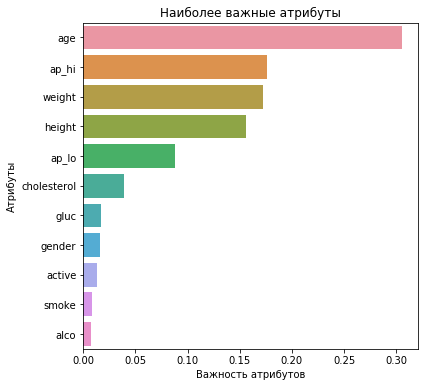

In [10]:
# Наиболее важные атрибуты для модели Random Forest:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
# plt.legend()
plt.show()

**Вывод:**
Больше всего на наличие/отсутствие болезни больше всего влияет возраст.

## 4. Выдвижение и проверка гипотезы

### Возраст

Text(0.5, 1.0, 'Частотный график возрастов')

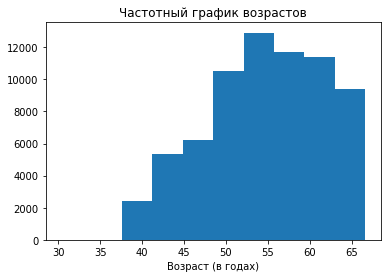

In [11]:
plt.hist(x.age/356)
plt.xlabel('Возраст (в годах)')
plt.title('Частотный график возрастов')

In [12]:
data.describe().age/356 # в годах

count    196.629213
mean      54.687825
std        6.930482
min       30.331461
25%       49.617978
50%       55.345506
75%       59.907303
max       66.609551
Name: age, dtype: float64

В данных представлены люди в возрасте от 30 до 67 лет. 

Половина обследуемых - до 30...55 лет, другая - 55...67 лет.

**Гипотеза H0: обследуемые моложе 55 и старше 55 болеют одинаково.**

In [13]:
until55 = data[data.age<=data.age.quantile()].cardio
older55 = data[data.age>data.age.quantile()].cardio

In [14]:
# !pip install researchpy
import researchpy as rp

In [15]:
descriptives, results = rp.ttest(until55, older55)

print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  35008.0  0.403365  0.490580  0.002622   0.398226  0.408504
1    cardio  34992.0  0.596079  0.490689  0.002623   0.590938  0.601221
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1927
1            Degrees of freedom =   69998.0000
2                             t =     -51.9607
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.3928
7                     Hedge's g =      -0.3928
8                 Glass's delta =      -0.3928
9                             r =       0.1927


**Вывод:** p-value равно нулю, т.е. существует существеное различие между двумя выборками по возрастам.

Почти 60% людей старше 55 лет болеют, а из "молодых" только 40%.

### Второе по "силе" - верхнее давление

In [16]:
# plt.hist(data.ap_hi)
x.describe().ap_hi

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

**Вывод:** в данных явные выбросы: отрицательным давление быть не может, как и значительно больше 250. Данные необходимо отфильтровать.

In [17]:
import statistics
print('Верхнее давление (статистика):')
print('- в исходных данных:')
print(f'среднее {statistics.mean(data.ap_hi):.2f}, стандартное отклонение {statistics.pstdev(data.ap_hi):.2f}')
data_filtered = data[(data.ap_hi > 90) & (data.ap_hi < 300)]
print('- в отфильтрованных данных:')
print(f'среднее {statistics.mean(data_filtered.ap_hi):.2f}, стандартное отклонение {statistics.pstdev(data_filtered.ap_hi):.2f}')

Верхнее давление (статистика):
- в исходных данных:
среднее 128.82, стандартное отклонение 154.01
- в отфильтрованных данных:
среднее 127.62, стандартное отклонение 16.51


127.62429176922964 16.50892089058701


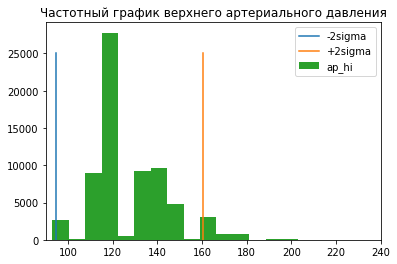

In [18]:
mean_val = statistics.mean(data_filtered.ap_hi)
st_deviation = statistics.pstdev(data_filtered.ap_hi)
print(mean_val, st_deviation)
plt.xlim(90, 240)

plt.plot([mean_val-2*st_deviation, mean_val-2*st_deviation], [0, 25000])
plt.plot([mean_val+2*st_deviation, mean_val+2*st_deviation], [0, 25000])
plt.hist(data_filtered.ap_hi, bins=20)

plt.title('Частотный график верхнего артериального давления')
plt.legend(['-2sigma','+2sigma','ap_hi'])

In [19]:
med = statistics.median(data_filtered.ap_hi)
upto120 = data_filtered[data_filtered.ap_hi <= med].cardio
more120 = data_filtered[data_filtered.ap_hi > med].cardio

### Гипотеза H0: люди с давлением меньше 120 и больше 120 болеют одинаково

In [20]:
descriptives, results = rp.ttest(upto120, more120)

print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  39434.0  0.320815  0.466796  0.002351   0.316207  0.325422
1    cardio  29223.0  0.752969  0.431293  0.002523   0.748023  0.757914
2  combined  68657.0  0.504756  0.499981  0.001908   0.501016  0.508495
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.4322
1            Degrees of freedom =   68655.0000
2                             t =    -123.8601
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.9560
7                     Hedge's g =      -0.9560
8                 Glass's delta =      -0.9258
9                             r =       0.4274


**Bывод:** p-value = 0, что опровергает гипотезу H0, т.е. давление сказывается на болезни сердца - низкое давление болезней относительно мало (32% людей), высокое давление - практически гарантия наличия заболеваний у 75% людей.